# Import libraries

In [1]:
# !pip install tensorflow==2.8
# !pip install tensorflowjs
# !pip install numpy==1.21
# !pip install protobuf==3.20.*
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn

In [2]:
import pathlib
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.utils import set_random_seed
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

In [3]:
import tensorflowjs as tfjs

# Setting a seed
Setting a seed so we can guarantee the same results no matter how many times we run the script

In [4]:
seed = 1305
np.random.seed(seed)
set_random_seed(seed)

# Setting the image directory

In [5]:
train_path = pathlib.Path("./data/train")
val_path = pathlib.Path('./data/val')
test_path = pathlib.Path('./data/test')

train_data = list(train_path.glob('*/*.jpeg'))

In [6]:
subpath = list(train_path.glob('*'))
species = []
boxplot_data = []

for i in range (0, len(subpath)):
    species.append(subpath[i].name)
    boxplot_data.append([subpath[i].name, len(os.listdir(subpath[i]))])

species.sort()
species

['1355932',
 '1355936',
 '1355937',
 '1355990',
 '1356022',
 '1356075',
 '1356257',
 '1356382',
 '1356781',
 '1357330',
 '1357635',
 '1358094',
 '1358095',
 '1358133',
 '1358689',
 '1358752',
 '1358766',
 '1359498',
 '1359517',
 '1359616',
 '1359620',
 '1360978',
 '1361656',
 '1361823',
 '1361824',
 '1362490',
 '1363128',
 '1363130',
 '1363227',
 '1363336',
 '1363740',
 '1363764',
 '1363991',
 '1364099',
 '1364159',
 '1364164',
 '1364173',
 '1367432',
 '1369887',
 '1374048',
 '1384485',
 '1385937',
 '1389510',
 '1392475',
 '1393241',
 '1393423',
 '1393425',
 '1393614',
 '1394382',
 '1394420',
 '1394454',
 '1394460',
 '1394591',
 '1394994',
 '1396824',
 '1397268',
 '1397364',
 '1398178',
 '1398592',
 '1400100',
 '1408774',
 '1408961',
 '1409238',
 '1418146',
 '1435714']

In [7]:
no_of_files = pd.DataFrame(columns=['Species', 'No of files'], data=boxplot_data)
count_more_than_1000 = 0
list_of_species_to_keep = []

for index, row in no_of_files.iterrows():
    if row['No of files'] >= 1000:
        count_more_than_1000 += 1
        list_of_species_to_keep.append(row['Species'])
        
list_of_species_to_keep        
count_more_than_1000

65

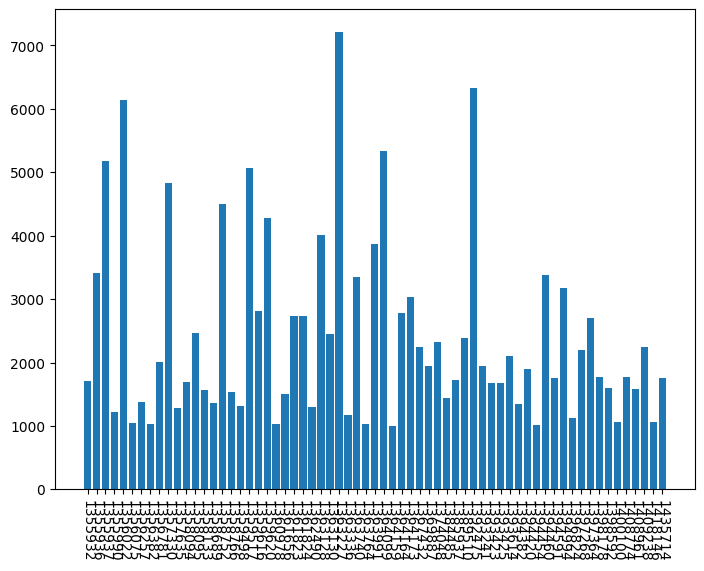

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plot_species = no_of_files['Species']
plot_numbers = no_of_files['No of files']
ax.bar(plot_species,plot_numbers)
plt.xticks(rotation = -90)
plt.show()

# Setting image height and width

In [9]:
image_size = (100, 100) # (height, width)

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=1337,
    image_size=image_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=1337,
    image_size=image_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=1337,
    image_size=image_size
)

Found 157722 files belonging to 65 classes.
Found 19759 files belonging to 65 classes.
Found 19753 files belonging to 65 classes.


# Setting the model

In [11]:
model = Sequential()

# adding layers
model.add(Conv2D(25, (5, 5), input_shape=(image_size[0], image_size[1], 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Conv2D(50, (5, 5), input_shape=(image_size[0], image_size[1], 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(len(species), activation='softmax'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 25)      1900      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 25)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 50)        31300     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 50)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 31250)             0         
                                                                 
 dense (Dense)               (None, 250)               7

# Setting epochs and fitting the model

In [13]:
epochs=10

In [14]:
result = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=300) #batch_size=1

Epoch 1/10
4929/4929 [==============================] - 160s 31ms/step - loss: 4.2974 - accuracy: 0.0627 - val_loss: 3.6741 - val_accuracy: 0.1027
Epoch 2/10
4929/4929 [==============================] - 112s 23ms/step - loss: 3.3990 - accuracy: 0.1558 - val_loss: 3.1097 - val_accuracy: 0.2065
Epoch 3/10
4929/4929 [==============================] - 108s 22ms/step - loss: 2.9504 - accuracy: 0.2416 - val_loss: 3.0697 - val_accuracy: 0.2196
Epoch 4/10
4929/4929 [==============================] - 108s 22ms/step - loss: 2.6070 - accuracy: 0.3168 - val_loss: 3.0128 - val_accuracy: 0.2614
Epoch 5/10
4929/4929 [==============================] - 109s 22ms/step - loss: 2.2040 - accuracy: 0.4148 - val_loss: 3.5306 - val_accuracy: 0.2391
Epoch 6/10
4929/4929 [==============================] - 107s 22ms/step - loss: 1.7988 - accuracy: 0.5149 - val_loss: 4.4352 - val_accuracy: 0.2226
Epoch 7/10
4929/4929 [==============================] - 108s 22ms/step - loss: 1.4764 - accuracy: 0.5963 - val_loss: 5

# Graph of loss change and accuracy change on train and val datasets

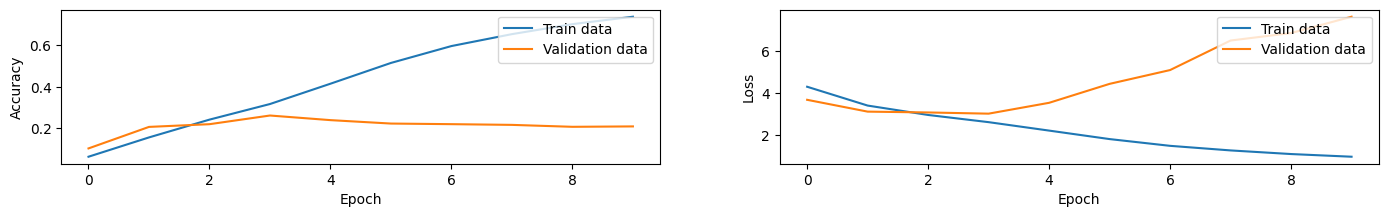

In [15]:
history = result

acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.figure(figsize=(17, 2))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_train, label='Train data')
plt.plot(range(epochs), acc_val, label='Validation data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss_train, label='Train data')
plt.plot(range(epochs), loss_val, label='Validation data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [16]:
scores = model.evaluate(val_ds, verbose=0)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])

Val loss: 7.640763282775879
Val accuracy: 0.20886684954166412


In [17]:
predictions = model.predict(test_ds)
#print('Predictions:\n', predictions.numpy())

In [18]:
print('Predictions:\n', predictions[np.argmax(tf.nn.softmax(predictions[0]))])
test_scores = model.evaluate(test_ds, verbose=0)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Predictions:
 [0.01629914 0.05180775 0.01136733 0.00161591 0.03860312 0.02186706
 0.00037958 0.0023915  0.03963503 0.01140667 0.00274395 0.00840427
 0.00873336 0.01334251 0.01441297 0.01732402 0.00933157 0.00190733
 0.0124428  0.00609439 0.20474838 0.00074702 0.00228492 0.00732265
 0.01100348 0.01921723 0.00154574 0.01674585 0.0124517  0.01632599
 0.00145675 0.02214648 0.00454138 0.03629203 0.00096159 0.04187554
 0.01171229 0.01643915 0.0032333  0.00176974 0.01463201 0.00683145
 0.00143742 0.00287142 0.01328199 0.00506486 0.01879347 0.00316349
 0.0003     0.01839722 0.00868205 0.00808382 0.00492975 0.00141731
 0.00195731 0.03353662 0.0193708  0.01422144 0.02867186 0.00158776
 0.0107546  0.02156026 0.00783324 0.00601418 0.02367416]
Test loss: 7.603801250457764
Test accuracy: 0.21019591391086578


# Saving the model
Firstly we save it in the default format and then the HDF5 format.

In [28]:
model_version = '0.1.1'

In [29]:
model.save('./exported_models/v'+model_version+'/botaniai_model_'+model_version+'.keras')

In [30]:
model.save('./exported_models/v'+model_version+'/botaniai_model_'+model_version+'.h5', save_format='h5')

In [33]:
model_json = model.to_json()
with open('./exported_models/v'+model_version+'/botaniai_model_'+model_version+'.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('./exported_models/v'+model_version+'/botaniai_model_weights_'+model_version+'.h5')
print("Saved model to disk")

Saved model to disk


# Convert model to tensorflow.js format

In [32]:
tfjs.converters.save_keras_model(model, './tensorflowjs/v'+model_version+'/')